In [1]:
# Libraries:
import pyabc
import fitmulticell as fmc
import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt
import tidynamics      
from pyabc import SingleCoreSampler

ERROR:External:Install rpy2 to enable simple support for the R language.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pipeline-comparison-before-and-after-adding-weights-to-distance-function" data-toc-modified-id="Pipeline-comparison-before-and-after-adding-weights-to-distance-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pipeline comparison before and after adding weights to distance function</a></span><ul class="toc-item"><li><span><a href="#Unweighted-pipeline:" data-toc-modified-id="Unweighted-pipeline:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Unweighted pipeline:</a></span></li><li><span><a href="#Adding-weights-based-on-previous-simulations:" data-toc-modified-id="Adding-weights-based-on-previous-simulations:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Adding weights based on previous simulations:</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Normalizing-the-MSD-for-the-SS" data-toc-modified-id="Normalizing-the-MSD-for-the-SS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Normalizing the MSD for the SS</a></span></li><li><span><a href="#Outlook" data-toc-modified-id="Outlook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Outlook</a></span></li></ul></div>

## Pipeline comparison before and after adding weights to distance function

### Unweighted pipeline:
External simulation of model with 100 sweeps, 200 time steps, and time coarseinng of 1.

In [43]:
# Collecting data from Morpheus in a sweep:

# Folder path with sweep generated by Morpheus:
path = '/Volumes/Sebi/FitMultiCell/Data_for_fitting/PRW_extended_with_LevyWalk_spontaneous_repolarization_sweep_25/'
def total_tracks(path, iterations, total_time, init_time):
    """
    Returns a ndarray with the total number of iterations/sweeps to average, 
    the time step between consecutive tracks and the initial time to 
    take the data (avoiding thermalization effects).
    """
    sweeps = os.listdir(path)
    sweeps.remove('sweep_header.csv')
    sweeps.remove('sweep_data.csv')
    #sweeps.remove('.DS_Store')# Sometimes needed if running in Mac
    sweeps.sort()
    data = np.zeros((iterations, total_time-init_time, 3))
    data_vel = np.zeros((iterations, total_time-init_time, 3))
    #count = 0
    for i in range(len(sweeps)):
        sweep_path = path + sweeps[i] + '/'
        cell_trajectory = pd.read_csv(sweep_path + 'logger.csv',
                                        sep='\t',header=(0))
        data[i,:,:] = np.array(cell_trajectory[['time', 'cell.center.x', 'cell.center.y']].iloc[init_time:])
        data_vel[i,:,:] = np.array(cell_trajectory[['velocity.x', 'velocity.y', 'velocity.abs']].iloc[init_time:])

    return data, data_vel

In [44]:
# This simulation was performed with 100 sweeps for 501 time points and took the data after time = 100
# Cells trajectories:
data_frame = total_tracks(path, 100, 201, 100)[0]
# Cells velocities:
data_vel = total_tracks(path, 100, 201, 100)[1]
# Avoiding 0 on velocity norm
norm = data_vel[:, :, 2]
norm[norm == 0] = 0.0001
data_vel[:, :, 2] = norm

In [57]:
def avg_MSD(df):
    time_points = len(df[0,:,0])
    MSD = np.zeros(time_points)

    for i in range(len(df[:])):
        p = tidynamics.msd(df[i,:, 1:3])
        MSD += p
    return (MSD / len(df[:]))

def avg_DAC(df):
    time_points = len(df[0,:,0])
    DAC = np.zeros(time_points)

    for i in range(len(df[:])):
        t = tidynamics.acf(np.column_stack([df[i,:,0] / df[i, :, 2], df[i,:,1] / df[i, :, 2]]))
        DAC += t
    return (DAC / len(df[:]))

MSD_sim = avg_MSD(data_frame)
DAC_sim = avg_DAC(data_vel)

In [58]:
MSD_coarse, DAC_coarse = [], []
for i in range(0, 100):
    MSD_coarse.append(MSD_sim[i])
    DAC_coarse.append(DAC_sim[i])

measured_data = {'IdSumstat__time': np.array([i for i in np.arange(0, 100)]),\
                 'IdSumstat__MSD': np.array(MSD_coarse),\
                 'IdSumstat__DAC': np.array(DAC_coarse)}

In [60]:
file_ = "PRW_Thesis.xml"
par_map = {'tau': './Global/Constant[@symbol="tau"]',
           'phi': './Global/Constant[@symbol="phi"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="/Applications/Morpheus.app/Contents/MacOS/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

MorpheusModel {
	name      : PRW_Thesis.xml
}


In [76]:
true_pars = {'tau': 0.9, 'phi': 0.1}
limits = {key: (0.1 * val, 10 * val) for key, val in true_pars.items()}

prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

# manually defined summary statistics

def distanceMSD(val1, val2):
    d = np.sum(np.abs(tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][101:],val1['IdSumstat__cell.center.y'][101:]]))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][101:]/val1['IdSumstat__velocity.abs'][101:],val1['IdSumstat__velocity.y'][101:]/val1['IdSumstat__velocity.abs'][101:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

In [77]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#sampler=SingleCoreSampler()
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=10, start_time=2020-11-18 15:49:40.792744, end_time=None)>


In [78]:
abc.run(max_nr_populations = 7)# min_epsilon = 0.1, max_nr_populations = 4

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 23832.10848515003
INFO:ABC:t: 0, eps: 23832.10848515003.
INFO:ABC:Acceptance rate: 100 / 160 = 6.2500e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 23694.277217138144.
INFO:ABC:Acceptance rate: 100 / 401 = 2.4938e-01, ESS=7.3687e+01.
INFO:ABC:t: 2, eps: 23384.12514396509.
<ipython-input-76-b8ca89dc2a8d>:15: RuntimeWarning: invalid value encountered in true_divide
  d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][101:]/val1['IdSumstat__velocity.abs'][101:],val1['IdSumstat__velocity.y'][101:]/val1['IdSumstat__velocity.abs'][101:]]))\
INFO:ABC:Acceptance rate: 100 / 631 = 1.5848e-01, ESS=9.4046e+01.
INFO:ABC:t: 3, eps: 22039.563712738298.
INFO:ABC:Acceptance rate: 100 / 432 = 2.3148e-01, ESS=9.2348e+01.
INFO:ABC:t: 4, eps: 18757.8620697372.
INFO:ABC:Acceptance rate: 100 / 294 = 3.4014e-01, ESS=6.6835e+01.
INFO:ABC:t: 5, eps: 14508.070052734854.
INFO:ABC:Acceptance rate: 100 / 505 = 1.9802e-0

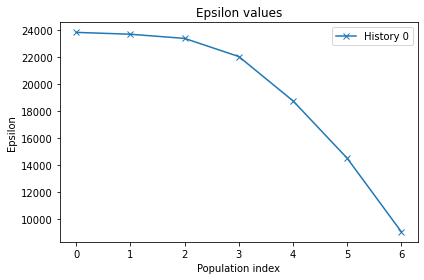

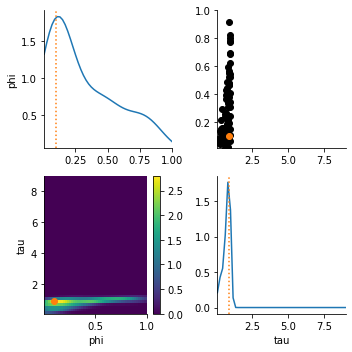

In [79]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)#h.max_t
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

### Adding weights based on previous simulations:
It is possible to set weights for each of the distance functions using the pyabc.AggregateDistance(.) class. The weight values can be used to tune the contribution of each SS distance function to the minimization of epsilon. In this section, the weights are chosen in a straighforward manner from previous observations of the ABC computation. The values are related to the order of magnitude for epsilon in previous simulations. One could maybe avoid this by using normalized SS, which will be attempted on the next section.

In [81]:
distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC], [0.001, 1])

In [82]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#sampler=SingleCoreSampler()
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=11, start_time=2020-11-18 16:08:06.219791, end_time=None)>


In [83]:
abc.run(max_nr_populations = 7)# min_epsilon = 0.1, max_nr_populations = 4

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 59.0047462081851
INFO:ABC:t: 0, eps: 59.0047462081851.
INFO:ABC:Acceptance rate: 100 / 247 = 4.0486e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 57.7914736310088.
INFO:ABC:Acceptance rate: 100 / 699 = 1.4306e-01, ESS=8.9349e+01.
INFO:ABC:t: 2, eps: 56.792915519959664.
INFO:ABC:Acceptance rate: 100 / 771 = 1.2970e-01, ESS=8.0824e+01.
INFO:ABC:t: 3, eps: 55.45211845548039.
INFO:ABC:Acceptance rate: 100 / 1450 = 6.8966e-02, ESS=8.6450e+01.
INFO:ABC:t: 4, eps: 47.35826059488829.
<ipython-input-76-b8ca89dc2a8d>:15: RuntimeWarning: invalid value encountered in true_divide
  d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][101:]/val1['IdSumstat__velocity.abs'][101:],val1['IdSumstat__velocity.y'][101:]/val1['IdSumstat__velocity.abs'][101:]]))\
INFO:ABC:Acceptance rate: 100 / 1080 = 9.2593e-02, ESS=9.1492e+01.
INFO:ABC:t: 5, eps: 33.898311452476754.
INFO:ABC:Acceptance rate: 100 / 801 = 1.2484e-01

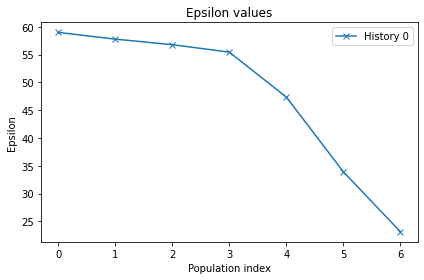

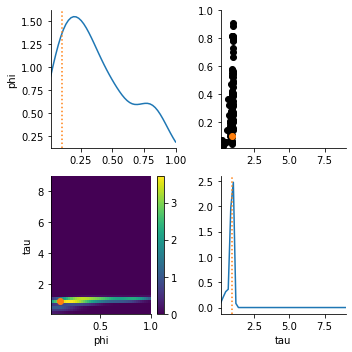

In [84]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)#h.max_t
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()

### Conclusion
Similar results for the parameter recovery. The pipeline with weighted distance had higher acceptance rates with respect to the same epoch run of the previous pipeline.

## Normalizing the MSD for the SS

Setting the correct weights for the distance function might not always be straightforward as the characteristics of the model/experiment (such as total running time, etc.) can vary. Instead, normalizing the MSD function will produce two SS over the same range and the weighting problem will not be so critical.
The MSD can be normalized using:

$$
NMSD = \frac{MSD}{4 \langle r^2\rangle},
$$

where $\langle r^2 \rangle$ is the average of the positions' squared-value (see [Whats, F. et al. 2013](https://iopscience.iop.org/article/10.1088/2040-8978/16/1/015301/meta)).

In [135]:
# For experimental/externally simulated data:
avg_norm = []
for i in range(100):
    trajectory = data_frame[i, :, 1:3] - data_frame[i, 0, 1:3]
    avg_norm.append(np.average(np.sum(trajectory*trajectory, axis = 1)))
    #avg_norm += r2
    
normalization = sum(avg_norm) / 100

MSD_norm = MSD_sim / (2*normalization)

In [137]:
MSD_coarse, DAC_coarse = [], []
for i in range(0, 100):
    MSD_coarse.append(MSD_norm[i])
    DAC_coarse.append(DAC_sim[i])

measured_data = {'IdSumstat__time': np.array([i for i in np.arange(0, 100)]),\
                 'IdSumstat__MSD': np.array(MSD_coarse),\
                 'IdSumstat__DAC': np.array(DAC_coarse)}

In [138]:
def MSD_normalized(data, t0):
    n = np.column_stack([data['IdSumstat__cell.center.x'][t0:], data['IdSumstat__cell.center.y'][t0:]])
    norm = n - n[0, :]
    avg_norm = np.average(np.sum(norm*norm, axis=1))
    return 2 * avg_norm

In [148]:
def distanceMSD(val1, val2):
    d = np.sum(np.abs((tidynamics.msd(np.column_stack([val1['IdSumstat__cell.center.x'][101:],val1['IdSumstat__cell.center.y'][101:]])))/(MSD_normalized(val1, 101))\
                      - val2['IdSumstat__MSD']))
    return d

def distanceDAC(val1, val2):
    d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][101:]/val1['IdSumstat__velocity.abs'][101:],val1['IdSumstat__velocity.y'][101:]/val1['IdSumstat__velocity.abs'][101:]]))\
                      - val2['IdSumstat__DAC']))
    return d

distance = pyabc.AggregatedDistance([distanceMSD, distanceDAC])

In [149]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=100, sampler=SingleCoreSampler())#sampler=SingleCoreSampler()
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, measured_data)

INFO:History:Start <ABCSMC(id=14, start_time=2020-11-19 08:08:18.718608, end_time=None)>


In [147]:
abc.run(max_nr_populations = 20)# min_epsilon = 0.1, max_nr_populations = 4

INFO:Epsilon:initial epsilon is 67.23162519496867
INFO:ABC:t: 7, eps: 67.23162519496867.
INFO:ABC:Acceptance rate: 100 / 197 = 5.0761e-01, ESS=3.6305e+01.
INFO:ABC:t: 8, eps: 55.471102000352346.
<ipython-input-144-eba4a84dcb3c>:7: RuntimeWarning: invalid value encountered in true_divide
  d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][101:]/val1['IdSumstat__velocity.abs'][101:],val1['IdSumstat__velocity.y'][101:]/val1['IdSumstat__velocity.abs'][101:]]))\
INFO:ABC:Acceptance rate: 100 / 294 = 3.4014e-01, ESS=5.9603e+01.
INFO:ABC:t: 9, eps: 46.04973487203238.
INFO:ABC:Acceptance rate: 100 / 675 = 1.4815e-01, ESS=8.1261e+01.
INFO:ABC:t: 10, eps: 40.126330443103285.
INFO:ABC:Acceptance rate: 100 / 967 = 1.0341e-01, ESS=6.1665e+01.
INFO:ABC:t: 11, eps: 34.487755409757185.
INFO:ABC:Acceptance rate: 100 / 1479 = 6.7613e-02, ESS=8.2907e+01.
INFO:ABC:t: 12, eps: 29.6355230501785.
INFO:ABC:Acceptance rate: 100 / 1877 = 5.3277e-02, ESS=7.1917e+01.
INFO:ABC:t: 13, 

KeyboardInterrupt: 

In [150]:
abc.run(max_nr_populations = 10)# min_epsilon = 0.1, max_nr_populations = 4

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 68.43898141130634
INFO:ABC:t: 0, eps: 68.43898141130634.
INFO:ABC:Acceptance rate: 100 / 183 = 5.4645e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 56.107791999926924.
INFO:ABC:Acceptance rate: 100 / 335 = 2.9851e-01, ESS=8.8203e+01.
INFO:ABC:t: 2, eps: 49.07542998663126.
INFO:ABC:Acceptance rate: 100 / 722 = 1.3850e-01, ESS=9.2680e+01.
INFO:ABC:t: 3, eps: 43.80793296825743.
<ipython-input-148-eba4a84dcb3c>:7: RuntimeWarning: invalid value encountered in true_divide
  d = np.sum(np.abs(tidynamics.acf(np.column_stack([val1['IdSumstat__velocity.x'][101:]/val1['IdSumstat__velocity.abs'][101:],val1['IdSumstat__velocity.y'][101:]/val1['IdSumstat__velocity.abs'][101:]]))\
INFO:ABC:Acceptance rate: 100 / 1748 = 5.7208e-02, ESS=8.5615e+01.
INFO:ABC:t: 4, eps: 41.278121976701854.
INFO:ABC:Acceptance rate: 100 / 2338 = 4.2772e-02, ESS=8.6513e+01.
INFO:ABC:t: 5, eps: 38.740522804642694.
INFO:ABC:Acceptance rate: 100 / 5549 = 1.802

## Outlook

Currently talking/planing with Synchon about using HPC services to have lunger runs and verify epsilon's convergence to a minimum.